# <p style='text-align: center;'>MA5851 Assessment 3 - Webcrawler and NLP System </p>
# <p style='text-align: center;'>Document 3, Part 1 - NLP Task 1</p>
### Author - Mathew Holden  
### Student No. - jc759971  

In [214]:
#dependencies for NLP task 1 - Regression model of ratings score
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import requests
import csv
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 200
from time import time, sleep
import math
import re
import nltk
import pickle
from nltk.corpus import wordnet
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import metrics

[nltk_data] Downloading package stopwords to C:\Users\Windows
[nltk_data]     7\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### NLP Task 1 - Regression model of Movie Ratings
<font size="4">There are many existing examples of movie review text being used a basis for sentiment analysis. This is sometimes performed by transforming a rating score into positive, negative and neutral categories then running a classification algorithm to classify each review accordingly. The aim of the task being undertaken here is to attempt to use a regression model to predict movie ratings based on review text. Even though a regression model should be used with a continuous variable it is hoped we will still obtain valuable insight into the text analysis of review comments in relation to the rating score. For example, a extremely positive review may actually be predicted greater than 10. This is still an indication of positive sentiment.

Using a score instead of a category provides an extra metric that can be used when reporting results. More degrees of sentiment can be discussed, imagine a really good movie, an average rating of 7 could appear almost identical to an average rating of 10 to a sentiment analysis problem. People understand a simple rating system and can immediately understand which movie review is considered better (or worse) with a single number.

There are several components required when creating this task.
1. Obtaining data.
2. Data wrangling
3. Text cleaning
4. Text feature extraction
5. Model Training and optimisation
6. Model deployment

Each of these items will discussed throughout this markdown document and related code is included.

### NLP Task 1 - Obtaining Data
<font size="4">Data relating to Academy award best picture winners and nominees has been scraped off oscars.org and imdb.com using selenium webcrawlers and condensed into 2 pickle files. For a full description please refer to Document 2 - Webcrawlers contained in this repository. For this task only the reviews data is required. It is able to be imported as a dataframe for further wrangling and cleaning.</font>

In [40]:
#load in dataframes from pickle files
reviews_df = pd.read_pickle("all_reviews.pkl")
print(reviews_df.head())

             Title        Date Rating  \
0  AMERICAN SNIPER  2015-07-06      8   
1  AMERICAN SNIPER  2015-02-10    NaN   
2  AMERICAN SNIPER  2017-04-17      7   
3  AMERICAN SNIPER  2015-12-08      7   
4  AMERICAN SNIPER  2016-01-14      5   

                                            Comments  
0  Although American Sniper did take one Oscar ho...  
1  American Sniper (2014) **** (out of 4)Thrillin...  
2  American Sniper is another true tale boasting ...  
3  Chris Kyle (Bradley Cooper) and his brother ar...  
4  I didn't get around to seeing this movie becau...  


### NLP Task 1 - Data wrangling and visualisation
<font size="4">The data imported should be almost ready to use. The webcrawlers used to extract this data utilised techniques to reduce the requirement for further wrangling. However we must still check for missing data and correct data types before continuing.

The code block below shows that there are 2,393 rows of data without a rating. We will need to remove those as rating will be the response variable for the regression. The data is ready for use once that is done. There are 92,621 valid movie reviews to use. There are 59 movies included in the data and a visualisation of reviews per movie is shown below in figure 1. The distribution of the ratings scores is shown in figure 2. The ratings are skewed heavily to 8, 9 and 10. We won't be able to transform the rating variable very succesfully as there is no long tail, so it will be better if we can obtain a sample of reviews with equal numbers of each rating.

A new dataframe, model\_df is created with a random selection of 1000 reviews from each score of rating from 1 to 10. The visualisations of the model\_df data is included in figures 3 and 4. There is still a similar distribution of reviews per movie, there could be bias due to that. To reduce the influence of the more popular movies would significantly reduce the size of the data available for training the model. This should be considered for future exploration. The movies used in this prototype are all best picture nominees, future work could include other less popular movies for training the model.

In [41]:
print("Na or Null Data by column:")
print(reviews_df.isna().sum())

Na or Null Data by column:
Title          0
Date           0
Rating      2393
Comments       0
dtype: int64


In [42]:
#We are interested in predicting rating data, so need to delete any rows without ratings
print("Reviews length before: {}".format(len(reviews_df)))
reviews_df = reviews_df.loc[reviews_df["Rating"].notna()]
print("Reviews length after: {}".format(len(reviews_df)))

Reviews length before: 95014
Reviews length after: 92621


Least number of reviews: 266


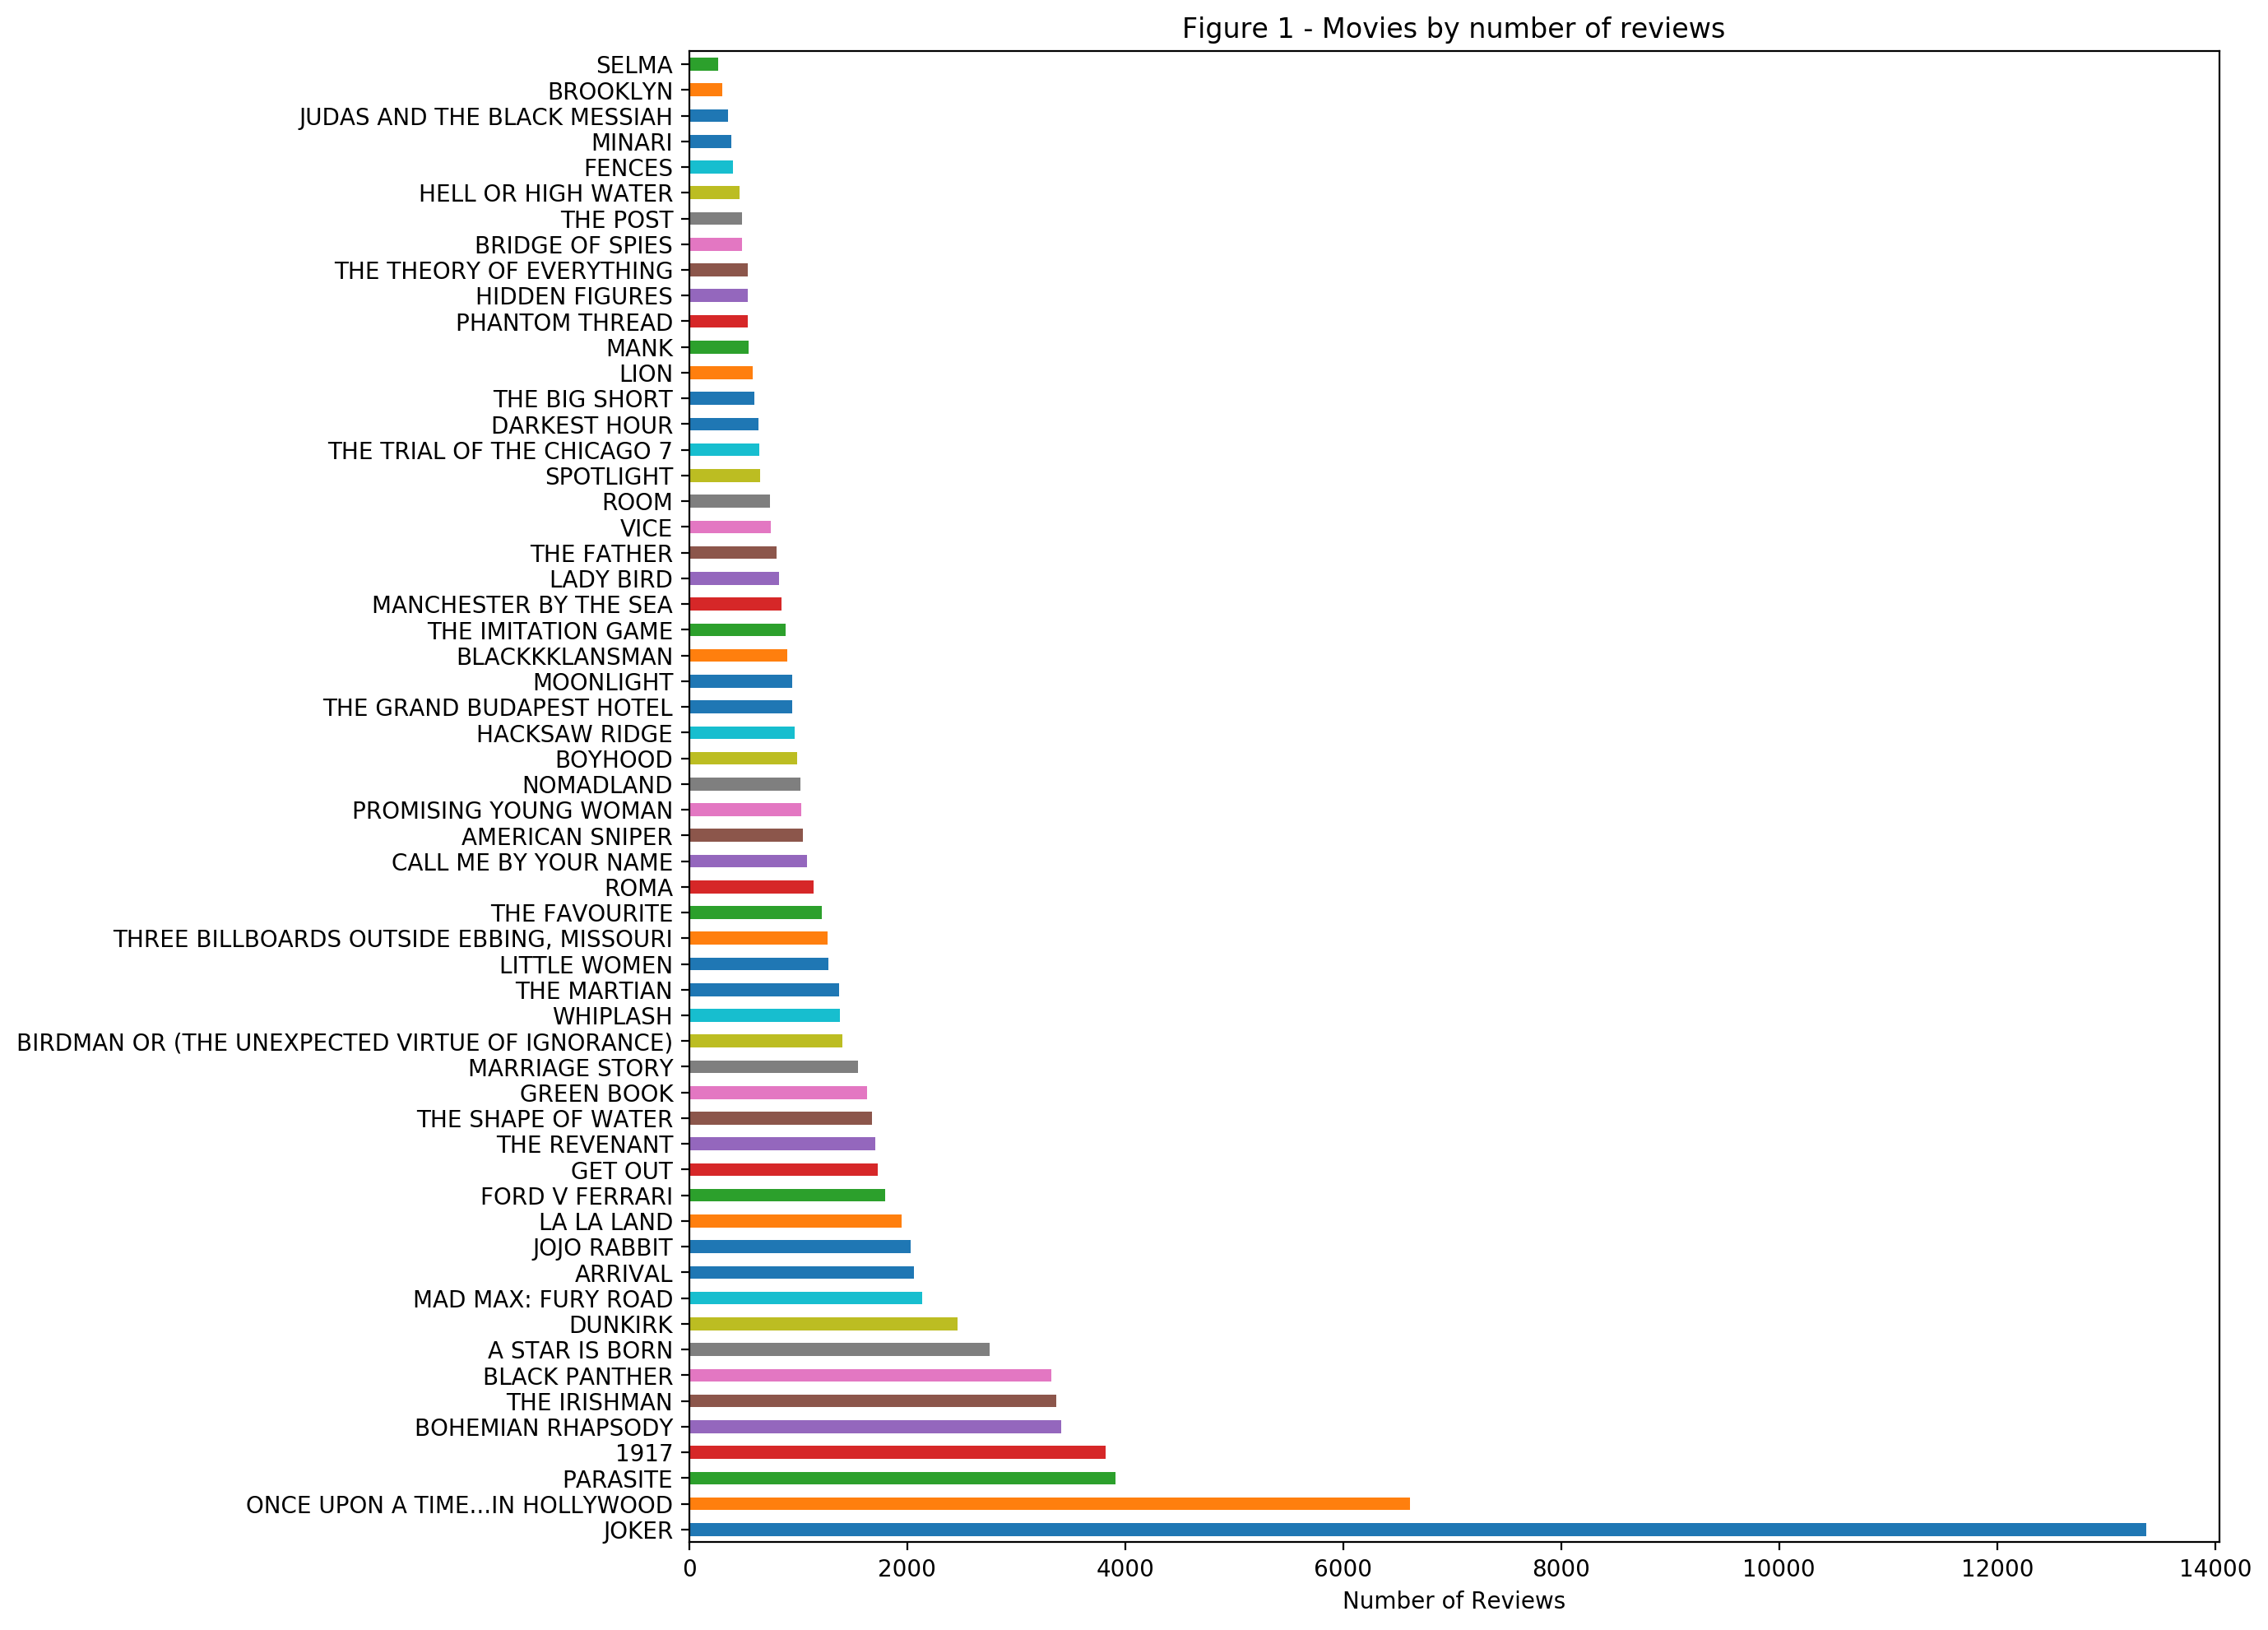

In [43]:
print("Least number of reviews: {}".format(reviews_df["Title"].value_counts()[-1]))
#Visualise the reviews per movie
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['figure.dpi'] = 200
#Visualise reviews per movie
reviews_df["Title"].value_counts().plot(kind='barh')
plt.xlabel('Number of Reviews')
plt.title('Figure 1 - Movies by number of reviews')

plt.show()

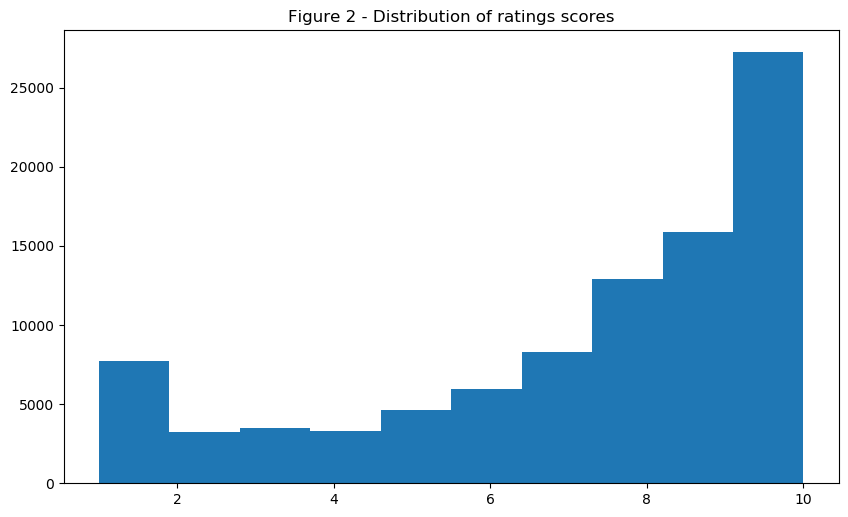

In [46]:
#visualise the ratings distribution.
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
plt.hist(reviews_df["Rating"], bins=10)
plt.title('Figure 2 - Distribution of ratings scores')
plt.show()

In [75]:
ratings_set = set(reviews_df["Rating"])
col_names = reviews_df.columns
model_df = pd.DataFrame(columns = col_names)
for rating in ratings_set:
    temp_df = reviews_df.loc[reviews_df['Rating'] == rating]
    model_df = model_df.append(temp_df.sample(n=1000))

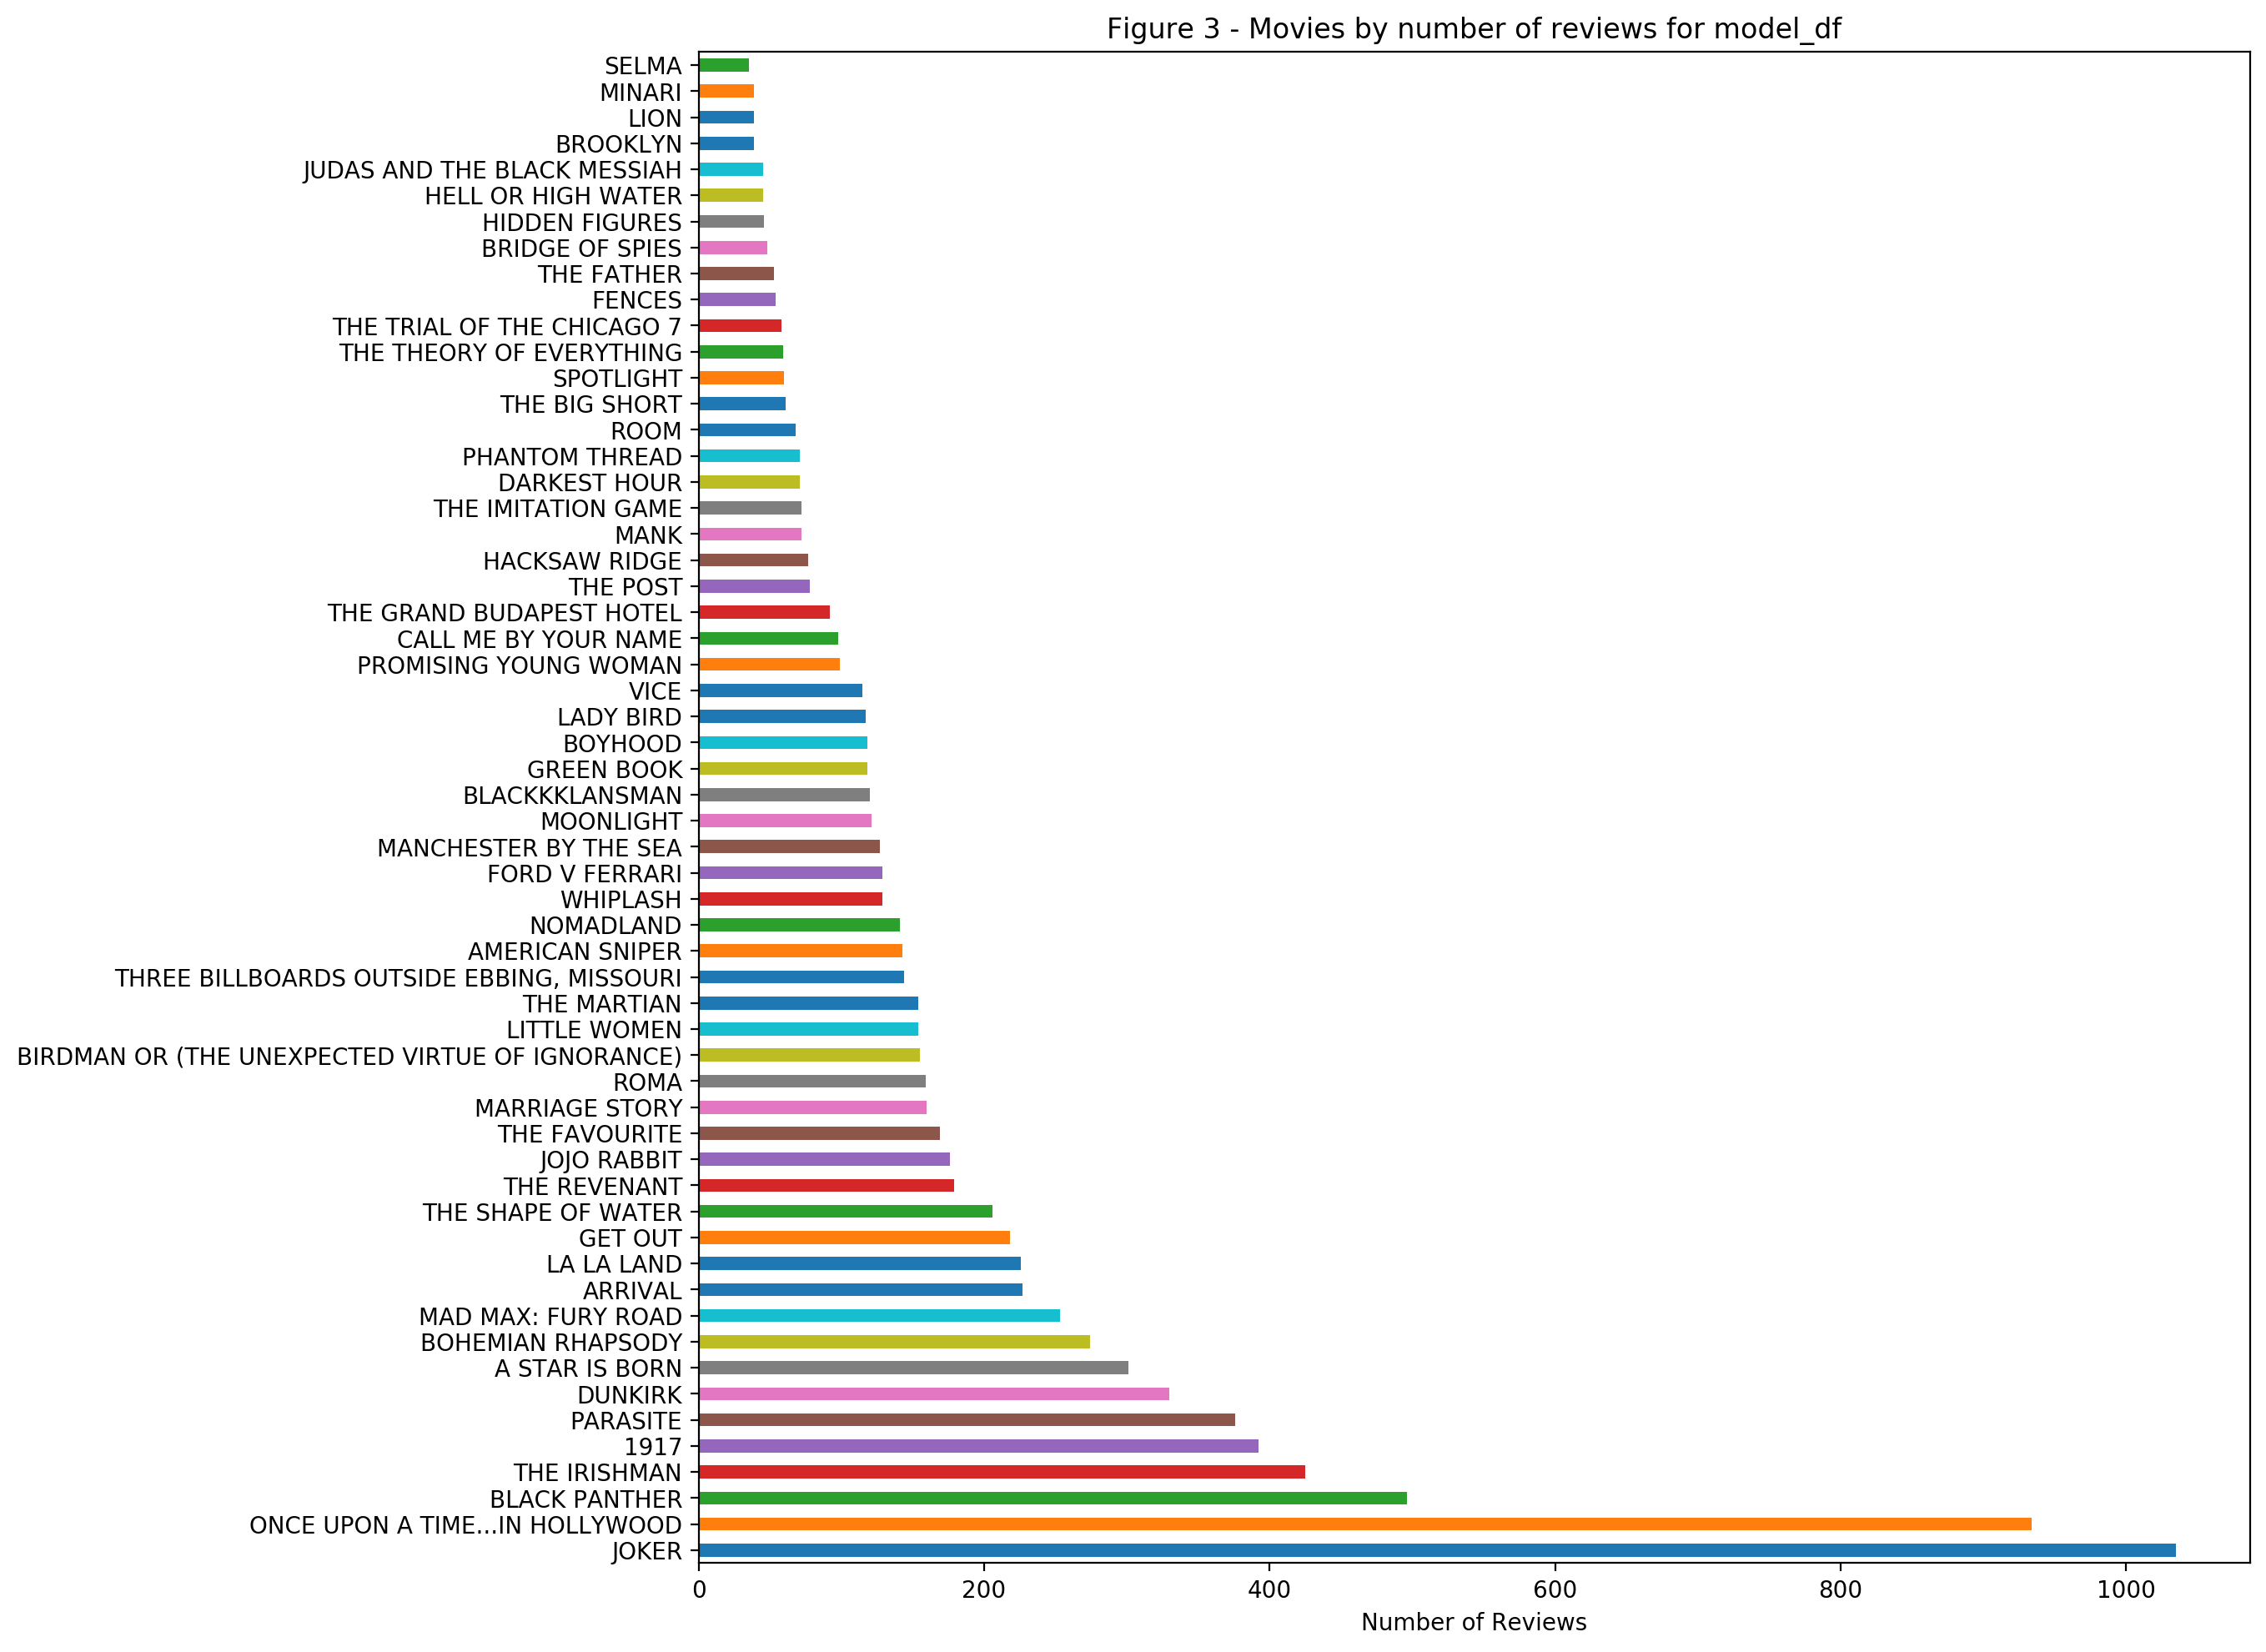

In [78]:
#Visualise the reviews per movie after model data selection
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['figure.dpi'] = 200
#Visualise reviews per movie
model_df["Title"].value_counts().plot(kind='barh')
plt.xlabel('Number of Reviews')
plt.title('Figure 3 - Movies by number of reviews for model_df')

plt.show()

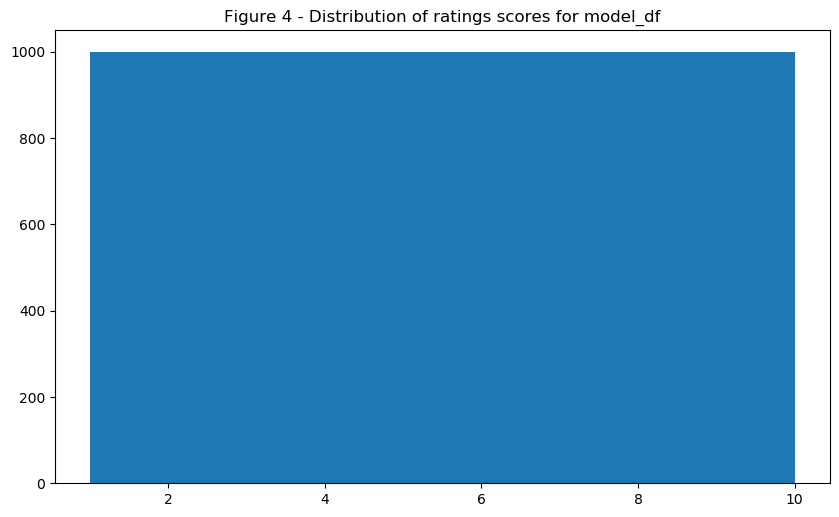

In [178]:
#visualise the ratings distribution.
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
plt.hist(model_df["Rating"], bins=10)
plt.title('Figure 4 - Distribution of ratings scores for model_df')
plt.show()

### NLP Task 1 - Text cleaning and feature extraction
<font size=4>The review comments data contained in the model\_df dataframe will be used to extract features for training the linear regression model with. For this NLP task we are interested in identifying adverbs, adjectives and nouns from the context of the review text. The function extract\_features takes the entire list of review comments and performs the following functions:
    1. Tokenizes each review using the regular expresion (r'\w+'). This will return words and numbers and strips out punctuation and whitespace.
    2. Uses the nltk.sent_tokenize function to tokenize each review into sentences.
    3. Tags the tokenized words using the nltk.pos_tag function.
    4. Filters words to return only adverbs, adjectives and nouns.
    5. Performs lemmatizing on the filtered word list to reduce words to base.
    6. Returns the cleaned and tokenized words, total words per review, average words per sentence and the average word length.
    
The function get\_data can be used to call the extract\_features function and split the returned dataframe into training and test data suitable for training and validation of the linear regression model. Text features are vectorized with the TfidfVectorizer() function from sklearn.feature_extraction.text package. The words per review, average words per sentence and the response variable are all normalized to between 0 and 1 with MinMaxScaler() function from sklearn.preprocessing package. Therefore all variables that will be used are normalised to the same scale.

In [276]:
#Function to extract nouns. adverbs and adjectives out of review comments
def extract_features(raw_corpus,first_tag = "JJ",second_tag = "RB", third_tag = "NN"):
    output_features = pd.DataFrame(columns = ['feature_text','total_words','words_per_sent','avg_word_len'])
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    for i in tqdm(raw_corpus.index):
        try:
            sent_text = nltk.sent_tokenize(raw_corpus[i])
        except:
            print(i)
            pass
        tokens = tokenizer.tokenize(raw_corpus[i])
        tokens = nltk.Text(tokens)
        total_words = len(tokens)
        #words per sentence
        words_per_sent = int(len(tokens)/len(sent_text))
        #average length of words
        avg_word_len = int(len(raw_corpus[i])/len(tokens))
        tagged_text = nltk.pos_tag(tokens)
        adj_adv_text = [(w,t) for (w,t) in tagged_text if t.startswith(first_tag)|t.startswith(second_tag)|t.startswith(third_tag)|t.startswith("V")]
        text_out = [lemmatizer.lemmatize(w) for (w,t) in adj_adv_text]
        text_out = ' '.join(text_out)
        text_out = text_out.lower()
        output_features.loc[len(output_features)] = [text_out,total_words,words_per_sent,avg_word_len]
    return output_features
        

In [192]:
def get_data(model_df,first_tag = "JJ",second_tag = "RB", third_tag = "NN",
            tfidf_ngram = (1,1), use_idf=True, max_df = 0.9, min_df = 0.001,
            extra_features = True):
    feature_df = extract_features(model_df["Comments"], first_tag, second_tag, third_tag)
    tfidf = TfidfVectorizer(ngram_range = tfidf_ngram, max_df=max_df, min_df=min_df,use_idf=use_idf)
    feature_df["total_words"] = MinMaxScaler().fit_transform(np.array(feature_df["total_words"]).reshape(-1,1))
    feature_df["words_per_sent"] = MinMaxScaler().fit_transform(np.array(feature_df["words_per_sent"]).reshape(-1,1)) 
    scaler = MinMaxScaler()
    response_df = scaler.fit_transform(np.array(model_df["Rating"]).reshape(-1,1))
    X_train, X_test, y_train, y_test = train_test_split(feature_df, response_df, test_size=0.25, random_state=42)
    tfidf.fit(X_train["feature_text"])
    if extra_features:
        xtrain_array = pd.concat([X_train["total_words"],X_train["words_per_sent"]],axis=1)
        xtest_array = pd.concat([X_test["total_words"],X_test["words_per_sent"]],axis=1)
        xtrain_add = xtrain_array.values
        xtest_add = xtest_array.values
        X_train = tfidf.transform(X_train["feature_text"]).toarray()
        X_test = tfidf.transform(X_test["feature_text"]).toarray()
        X_train = np.concatenate((X_train,xtrain_add),axis=1)
        X_test = np.concatenate((X_test,xtest_add),axis=1)
    else:
        X_train = tfidf.transform(X_train["feature_text"]).toarray()
        X_test = tfidf.transform(X_test["feature_text"]).toarray()
    return X_train, y_train, X_test, y_test, tfidf

### NLP Task 1 - Model Training and Optimisation
<font size=4>The machine learning algorithm being used is the Linear SVR from the sklearn.svm package. It is a support vector machine with a linear kernel. Future works could include applying SVR with other kernels. SVR_optimiser() function can take training and test data as inputs with a range of values for hyperparameters epsilon, C, loss and intercept_scaling. It returns a dataframe containing the following metrics:
    1. Mean of the Cross-validated scores for the training model.
    2. The coefficient of determination (R2) score for the training model.
    3. root mean squared error (rmse) of the validation data.
    4. mean absolute error (mae) of the validation data.
    5. The coefficient of determination (R2) score of the validation data.
Metrics rmse, mae and R2 for the validation model can be visualised with function plot_lsvr(). SVR_optimiser() was run twice with decreasing ranges for the hyperparameters. The hyperparameters chosen were epsilon=0.1, C=0.1, loss='epsilon_insensitive' and intercept_scaling=0.5.  
    
With optimised hyperparameters selected the model was run with features removed one at a time to determine if removing any could increase performance. It was determined including the words per review and average words per sentence variables did not have a significant affect so were removed from the feature set. All other features were left in.

The best performing model had the following metrics:  
Mean of the CV scores for the training model = 0.49584  
The coefficient of determination (R2) score for the training model = 0.68591  
rmse of validation data = 0.219016  
mae of validation data = 0.175268  
R2 of validation data = 0.520932  

If we scale up the rmse and mae we can see that our model should predict ratings with an average of 1.7 difference from the actual. The increase of the rmse compared to mae tells us there are outliers that are influencing the error. This is to be expected due to the random nature of user reviews. The R2 scores are positive which is good, and we can tell the model is doing a fair job of explaining the variation in our data. Overall the performance of the model is encouraging.

In [193]:
def SVR_optimiser(X_train, y_train, X_test, y_test, epsilon,C,loss,i_scaling):
    lsvr_scores_df = pd.DataFrame(columns = ['args','cv','train_r2','rmse','mae','r2'])
    for e in epsilon:
        for c in C:
            for l in loss:
                for i_s in i_scaling:
                    lsvr = LinearSVR(epsilon=e,
                                   tol=0.00001,
                                   C=c,
                                   loss=l,
                                   intercept_scaling=i_s,
                                   random_state=10,
                                   max_iter=1000)
                    lsvr = lsvr.fit(X_train, y_train)
                    y_pred = lsvr.predict(X_test)
                    cv_score = np.mean(cross_val_score(lsvr, X_train, y_train, cv=10))
                    train_score = lsvr.score(X_train, y_train)
                    test_mse = mean_squared_error(y_test, y_pred)
                    test_rmse = math.sqrt(test_mse)
                    test_mae = mean_absolute_error(y_test, y_pred)
                    test_r2 = r2_score(y_test, y_pred)
                    lsvr_scores_df.loc[len(lsvr_scores_df)] = [[e,c,l,i_s],cv_score,train_score,test_rmse,test_mae,test_r2]
    return lsvr_scores_df

def plot_lsvr(lsvr_scores_df):
    ax = plt.gca()
    lsvr_scores_df.plot(kind='line',x='args',y='rmse',ax=ax)
    lsvr_scores_df.plot(kind='line',x='args',y='mae', color='red', ax=ax)
    lsvr_scores_df.plot(kind='line',x='args',y='r2', color='green', ax=ax)

    plt.show()

In [194]:
#first run
X_train, y_train, X_test, y_test, tfidf = get_data(model_df,first_tag = "JJ",second_tag = "RB", third_tag = "NN",
            tfidf_ngram = (1,1), use_idf=True, max_df = 0.9, min_df = 0.001,
            extra_features = True)

100%|██████████| 10000/10000 [02:01<00:00, 82.09it/s]


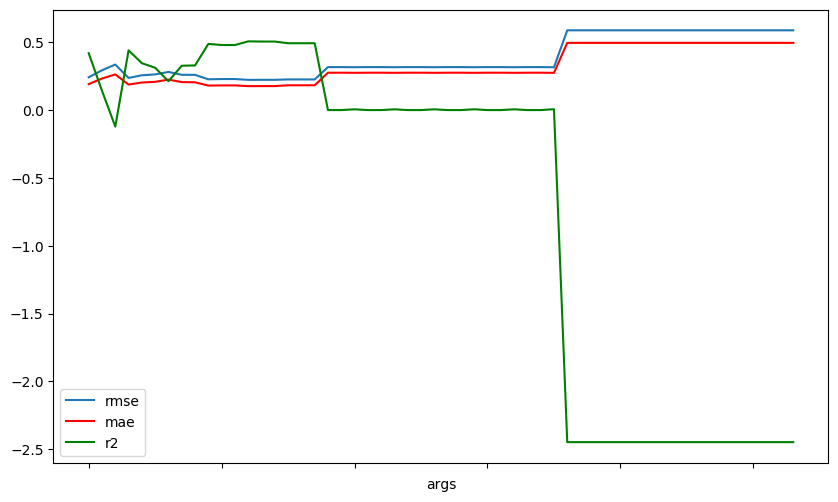

,args,cv,train_r2,rmse,mae,r2
0,"[0, 5, epsilon_insensitive, 20]",0.161377,0.811106,0.241243,0.191013,0.418762
1,"[0, 5, epsilon_insensitive, 10]",0.070546,0.807620,0.293042,0.232110,0.142362
2,"[0, 5, epsilon_insensitive, 1]",-0.217878,0.840560,0.335196,0.262647,-0.122128
3,"[0, 5, squared_epsilon_insensitive, 20]",0.274061,0.802201,0.236801,0.187622,0.439967
4,"[0, 5, squared_epsilon_insensitive, 10]",0.292709,0.850448,0.256087,0.202863,0.345033
5,"[0, 5, squared_epsilon_insensitive, 1]",0.260644,0.861964,0.262548,0.207931,0.311566
6,"[0, 1, epsilon_insensitive, 20]",0.291000,0.604460,0.280822,0.224273,0.212396
7,"[0, 1, epsilon_insensitive, 10]",0.298219,0.791705,0.259686,0.205859,0.326493
8,"[0, 1, epsilon_insensitive, 1]",0.301690,0.790588,0.259267,0.204433,0.328665
9,"[0, 1, squared_epsilon_insensitive, 20]",0.443230,0.765300,0.226603,0.180257,0.487168


In [195]:
#first run of data
epsilon = [0,0.5,1]
C = [5,1,0.1]
loss = ['epsilon_insensitive', 'squared_epsilon_insensitive']
i_scaling = [20,10,1]
lsvr_scores_df = SVR_optimiser(X_train, y_train, X_test, y_test, epsilon,C,loss,i_scaling)
plot_lsvr(lsvr_scores_df)
lsvr_scores_df

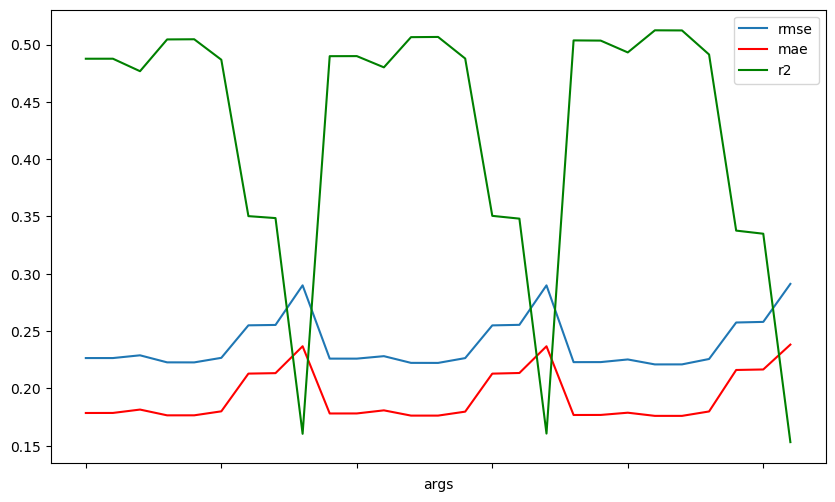

,args,cv,train_r2,rmse,mae,r2
0,"[0, 0.2, epsilon_insensitive, 1]",0.468415,0.702644,0.226501,0.178579,0.487628
1,"[0, 0.2, epsilon_insensitive, 0.5]",0.468378,0.702737,0.226497,0.178616,0.487647
2,"[0, 0.2, epsilon_insensitive, 0.1]",0.457246,0.697511,0.228893,0.181562,0.476747
3,"[0, 0.1, epsilon_insensitive, 1]",0.485884,0.649242,0.222747,0.176528,0.504471
4,"[0, 0.1, epsilon_insensitive, 0.5]",0.485921,0.649325,0.222715,0.176543,0.504613
5,"[0, 0.1, epsilon_insensitive, 0.1]",0.464431,0.634203,0.226693,0.180023,0.486758
6,"[0, 0.01, epsilon_insensitive, 1]",0.318019,0.371971,0.255053,0.212933,0.350310
7,"[0, 0.01, epsilon_insensitive, 0.5]",0.314197,0.369135,0.255387,0.213334,0.348607
8,"[0, 0.01, epsilon_insensitive, 0.1]",0.107886,0.179893,0.289943,0.236806,0.160405
9,"[0.01, 0.2, epsilon_insensitive, 1]",0.471186,0.704659,0.226008,0.178152,0.489855


In [198]:
#Best results are for 0,0.1,e_i, i_scaling doesn't have a great affect
#tighten up the parameters
epsilon = [0, 0.01,0.1]
C = [0.2,0.1,0.01]
loss = ['epsilon_insensitive']
i_scaling = [1,0.5,0.1]
lsvr_scores_df = SVR_optimiser(X_train, y_train, X_test, y_test, epsilon,C,loss,i_scaling)
plot_lsvr(lsvr_scores_df)
lsvr_scores_df

In [199]:
#No extra features
X_train, y_train, X_test, y_test, tfidf = get_data(model_df,first_tag = "JJ",second_tag = "RB", third_tag = "NN",
            tfidf_ngram = (1,1), use_idf=True, max_df = 0.9, min_df = 0.001,
            extra_features = False)

100%|██████████| 10000/10000 [02:09<00:00, 77.27it/s]


In [200]:
epsilon = [0.1]
C = [0.1]
loss = ['epsilon_insensitive']
i_scaling = [0.5]
lsvr_scores_df = SVR_optimiser(X_train, y_train, X_test, y_test, epsilon,C,loss,i_scaling)
lsvr_scores_df

,args,cv,train_r2,rmse,mae,r2
0,"[0.1, 0.1, epsilon_insensitive, 0.5]",0.490205,0.644806,0.221002,0.175993,0.512204


Not a huge difference with and without extra features, we will remove the extra features and just rely on text.

In [201]:
#no extra features, add 2 ngrams
X_train, y_train, X_test, y_test, tfidf = get_data(model_df,first_tag = "JJ",second_tag = "RB", third_tag = "NN",
            tfidf_ngram = (1,2), use_idf=True, max_df = 0.9, min_df = 0.001,
            extra_features = False)

100%|██████████| 10000/10000 [02:02<00:00, 81.53it/s]


In [202]:
epsilon = [0.1]
C = [0.1]
loss = ['epsilon_insensitive']
i_scaling = [0.5]
lsvr_scores_df = SVR_optimiser(X_train, y_train, X_test, y_test, epsilon,C,loss,i_scaling)
lsvr_scores_df

,args,cv,train_r2,rmse,mae,r2
0,"[0.1, 0.1, epsilon_insensitive, 0.5]",0.49584,0.68591,0.219016,0.175268,0.520932


In [203]:
#2 ngrams is slightly better will keep that.
#no extra features, add 2 ngrams, use_idf=False
X_train, y_train, X_test, y_test, tfidf = get_data(model_df,first_tag = "JJ",second_tag = "RB", third_tag = "NN",
            tfidf_ngram = (1,2), use_idf=False, max_df = 0.9, min_df = 0.001,
            extra_features = False)

100%|██████████| 10000/10000 [02:02<00:00, 81.53it/s]


In [204]:
epsilon = [0.1]
C = [0.1]
loss = ['epsilon_insensitive']
i_scaling = [0.5]
lsvr_scores_df = SVR_optimiser(X_train, y_train, X_test, y_test, epsilon,C,loss,i_scaling)
lsvr_scores_df

,args,cv,train_r2,rmse,mae,r2
0,"[0.1, 0.1, epsilon_insensitive, 0.5]",0.474056,0.611051,0.223422,0.177907,0.501465


In [205]:
#using idf is better
#no extra features, no nouns
X_train, y_train, X_test, y_test, tfidf = get_data(model_df,first_tag = "JJ",second_tag = "RB", third_tag = "JJ",
            tfidf_ngram = (1,2), use_idf=True, max_df = 0.9, min_df = 0.001, extra_features = False)

100%|██████████| 10000/10000 [02:05<00:00, 79.79it/s]


In [206]:
epsilon = [0.1]
C = [0.1]
loss = ['epsilon_insensitive']
i_scaling = [0.5]
lsvr_scores_df = SVR_optimiser(X_train, y_train, X_test, y_test, epsilon,C,loss,i_scaling)
lsvr_scores_df

,args,cv,train_r2,rmse,mae,r2
0,"[0.1, 0.1, epsilon_insensitive, 0.5]",0.41217,0.607023,0.235429,0.189854,0.446437


In [207]:
#removing nouns is significantly worse performance
#No extra features, no adverbs
X_train, y_train, X_test, y_test, tfidf = get_data(model_df,first_tag = "JJ",second_tag = "JJ", third_tag = "NN",
            tfidf_ngram = (1,2), use_idf=True, max_df = 0.9, min_df = 0.001, extra_features = False)

100%|██████████| 10000/10000 [02:03<00:00, 81.01it/s]


In [208]:
epsilon = [0.1]
C = [0.1]
loss = ['epsilon_insensitive']
i_scaling = [0.5]
lsvr_scores_df = SVR_optimiser(X_train, y_train, X_test, y_test, epsilon,C,loss,i_scaling)
lsvr_scores_df

,args,cv,train_r2,rmse,mae,r2
0,"[0.1, 0.1, epsilon_insensitive, 0.5]",0.486086,0.676523,0.2229,0.179087,0.50379


### NLP Task 1 - Model Deployment
<font size=4>The model for deployment is trained with the entire model_df dataframe. The model, vectorizer and scaler are saved as pickle files for easy deployment. The model can be deployed and updated remotely as long as it can be directed to the latest pickle files. lsvr_model_deploy() function takes an indexed list of text strings and returns a list of ratings scores in a 1-10 scale. If a list of reviews for a certain movie are entered, these scores can be averaged to provide an indication of sentiment. Alternatively a single users review can be entered and a single score will be returned to provide a guage of a users sentiment.
    
So the NLP task addresses the issue of being able to quantify sentiment based only on text based data relating to movies. Two examples are included in the code blocks below showing output.

In [211]:
#Need to break apart the get_data function so the tfidf is fitted correctly for predicting
feature_df = extract_features(model_df["Comments"])  #we want all features so defaults are good

100%|██████████| 10000/10000 [02:03<00:00, 81.15it/s]


In [212]:
#setting the variables for training the model
scaler = MinMaxScaler()
response_df = scaler.fit_transform(np.array(model_df["Rating"]).reshape(-1,1))
tfidf = TfidfVectorizer(ngram_range = (1,2), max_df=0.9, min_df=0.001,use_idf=False)
feature_df["total_words"] = MinMaxScaler().fit_transform(np.array(feature_df["total_words"]).reshape(-1,1))
feature_df["words_per_sent"] = MinMaxScaler().fit_transform(np.array(feature_df["words_per_sent"]).reshape(-1,1)) 
X = feature_df["feature_text"]
y_train = response_df
tfidf.fit(X)
X_train = tfidf.transform(X).toarray()

In [222]:
#Train the model and save it
lsvr = LinearSVR(epsilon=0.1,
                    tol=0.00001,
                    C=0.1,
                    loss='epsilon_insensitive',
                    intercept_scaling=0.5,
                    random_state=10,
                    max_iter=1000)
lsvr = lsvr.fit(X_train, y_train)
lsvr_Filename = "Pickle_lsvr_Model.pkl"  
tfidf_Filename = "Pickle_tfidf.pkl"
scaler_Filename = "Pickle_scaler.pkl"

pickle.dump(lsvr, open(lsvr_Filename, 'wb'))
pickle.dump(tfidf, open(tfidf_Filename, 'wb'))
pickle.dump(scaler, open(scaler_Filename, 'wb'))

In [318]:
#This is the deployable code. Note must be able to find extract_features function
#Load in saved model, vectorizer and scaler.
lsvr_Filename = "Pickle_lsvr_Model.pkl"  
tfidf_Filename = "Pickle_tfidf.pkl"
scaler_Filename = "Pickle_scaler.pkl"

loaded_lsvr = pickle.load(open(lsvr_Filename, 'rb'))
loaded_tfidf = pickle.load(open(tfidf_Filename, 'rb'))
loaded_scaler = pickle.load(open(scaler_Filename, 'rb'))

def lsvr_model_deploy(review):
    """Input a review as a text string, or a list of reviews as text strings. Will return the predicted
    rating."""
    model_test_df = extract_features(review,first_tag = "JJ",second_tag = "RB", third_tag = "NN")
    X = model_test_df["feature_text"]
    X_test = loaded_tfidf.transform(X).toarray()
    y_pred = loaded_lsvr.predict(X_test)
    y_pred_unscaled = loaded_scaler.inverse_transform(y_pred.reshape(-1,1))
    return y_pred_unscaled

In [325]:
#Try on some random data
random_df = reviews_df.sample(n=10)
y_pred = lsvr_model_deploy(random_df["Comments"])
y_test = random_df["Rating"]
for i in range(len(y_pred)):
    print("Actual Rating: {}   Predicted Rating: {}".format(y_test.iloc[i],y_pred[i]))

100%|██████████| 10/10 [00:00<00:00, 73.53it/s]

Actual Rating: 2   Predicted Rating: [0.13374046]
Actual Rating: 1   Predicted Rating: [3.09798632]
Actual Rating: 9   Predicted Rating: [6.59725731]
Actual Rating: 10   Predicted Rating: [9.60691973]
Actual Rating: 10   Predicted Rating: [6.36662251]
Actual Rating: 9   Predicted Rating: [6.92586573]
Actual Rating: 9   Predicted Rating: [6.42654582]
Actual Rating: 9   Predicted Rating: [7.1433213]
Actual Rating: 10   Predicted Rating: [9.9923406]
Actual Rating: 10   Predicted Rating: [4.4619392]


In [331]:
#randomly entered text, needs to be entered as dataframe for indexing
text1="Really liked this movie. Had great acting and awesome dircection. Should win awards for sure"
text2="Terrible, turned off after 10 minutes. Would not recommend, utter garbage"
text_df = pd.DataFrame([text1,text2],columns = ["Text"])
ratings = lsvr_model_deploy(text_df["Text"])
for i in range(len(ratings)):
    print("Predicted Rating: {}".format(ratings[i]))

100%|██████████| 2/2 [00:00<00:00, 133.33it/s]

Predicted Rating: [7.16825534]
Predicted Rating: [0.44000536]


# <p style='text-align: center;'>MA5851 Assessment 3 - Webcrawler and NLP System </p>
# <p style='text-align: center;'>Document 3, Part 2 - NLP Task 2</p>
### Author - Mathew Holden  
### Student No. - jc759971  

In [302]:
#dependencies for NLP task 2 - Classification model to predict best picture winner
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import requests
import csv
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from time import time, sleep
import datetime
import math
import re
import nltk
from nltk.corpus import wordnet
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, accuracy_score, f1_score,precision_score, recall_score, auc
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn import metrics

[nltk_data] Downloading package stopwords to C:\Users\Windows
[nltk_data]     7\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### NLP Task 2 - Classification model of Best Picture Oscar Nominees
<font size="4">This task uses natural language processing to analyse movie reviews from popular website imdb.com to attempt to predict the most likely winner of the best picture Oscar for a given year.

Predicting the winner of the best picture Oscar is normally left for film 'experts'. Iain Pardoe and Dean K. Simonton in their 2008 paper 'Applying discrete choice models to predict Academy Award winners' attempted to predict Oscar winners based on variables such as other award nominations and success. It doesn't appear that the strategy proposed here has been investigated previously.

The core of the task is to classify movie reviews as being for a winner of the best picture Oscar or not. The final model would then take a selection of reviews for all the best picture nominees for a selected year and provide a breakdown of which movie contains the largest percentage of "Winner" reviews. Therefore providing a breakdown of potential winners and losers.

There are several components required when creating this task.
1. Obtaining data.
2. Data wrangling
3. Text cleaning
4. Text feature extraction
5. Model Training and optimisation
6. Model deployment

Each of these items will discussed throughout this markdown document and related code is included.

### NLP Task 2 - Obtaining Data
<font size="4">Data relating to Academy award best picture winners and nominees has been scraped off oscars.org and imdb.com using selenium webcrawlers and condensed into 2 pickle files. For a full description please refer to Document 2 - Webcrawlers contained in this repository. For this task both datasets are required. They are able to be imported as dataframes for further wrangling and cleaning.</font>

In [282]:
#load in dataframes from pickle files
movies_df = pd.read_pickle("all_movies.pkl")
reviews_df = pd.read_pickle("all_reviews.pkl")
print(movies_df.head())
print(reviews_df.head())

   Year        Date                                            Title  Winner
0  2015  2015-02-22  BIRDMAN OR (THE UNEXPECTED VIRTUE OF IGNORANCE)    True
1  2015  2015-02-22                                  AMERICAN SNIPER   False
2  2015  2015-02-22                                          BOYHOOD   False
3  2015  2015-02-22                         THE GRAND BUDAPEST HOTEL   False
4  2015  2015-02-22                               THE IMITATION GAME   False
             Title        Date Rating  \
0  AMERICAN SNIPER  2015-07-06      8   
1  AMERICAN SNIPER  2015-02-10    NaN   
2  AMERICAN SNIPER  2017-04-17      7   
3  AMERICAN SNIPER  2015-12-08      7   
4  AMERICAN SNIPER  2016-01-14      5   

                                            Comments  
0  Although American Sniper did take one Oscar ho...  
1  American Sniper (2014) **** (out of 4)Thrillin...  
2  American Sniper is another true tale boasting ...  
3  Chris Kyle (Bradley Cooper) and his brother ar...  
4  I didn't get 

### NLP Task 2 - Data wrangling and visualisation
<font size="4">The data imported should be almost ready to use. The webcrawlers used to extract this data utilised techniques to reduce the requirement for further wrangling. The key to this task is identifying best picture Oscar winners from reviews, so the movie data needs to be merged with the review data to create dataframe merge\_df.

Checking the merge\_df dataframe for NA values shows there is 1 row without 'comments' or 'date_review'. By searching for that row we find the movie 'SOUND OF METAL'. We know from EDA of the extracted corpus that 'SOUND OF METAL' did not return any review comments when trying to scrape the imdb.com site. This row needs to be removed.

The variable to identify the best picture winners contains boolean values. This is the response variable for the classification problem. Converting these to integers will negate any further requirement for processing them before training the model.

The model should not be influenced by reviews of a movie after it is known to be the best picture winner. So only reviews that occur before the Oscar ceremony date are kept. The final dataframe for training the model is pre\_oscars\_df. Figure 1 shows the breakdown of reviews available for winners and non winners. It is to be expected that the winners count is much lower than non winners as in recent years there have normally been at least 8 movies nominated for the best picture oscar.

In [283]:
#merge the dataframes
merge_df = pd.merge(movies_df,reviews_df,how="outer", #outer join will keep all values in both datasets
    on='Title',                  #ISBN is the common key to both
    left_on=None,               #we have common key so don't need left_on or right_on
    right_on=None,
    left_index=False,           #don't need left_index or right_index
    right_index=False,
    sort=False,                 #don't need to sort. Will improve performance
    suffixes=("_oscars", "_review"), #separate common columns names
    copy=True,                  #leave as default
    indicator=False,             #will provide a column 'merge' which will define where the observation came from (both, left or right)
    validate=None,               #don't need to validate
)
print(len(merge_df))

95015


In [284]:
print("Na or Null Data by column:")
print(merge_df.isna().sum())

Na or Null Data by column:
Year              0
Date_oscars       0
Title             0
Winner            0
Date_review       1
Rating         2394
Comments          1
dtype: int64


In [285]:
print([merge_df.loc[i]["Title"] for i in merge_df.index if not isinstance(merge_df.loc[i]["Comments"],str)])

['SOUND OF METAL']


In [286]:
#we get rid of any rows where we don't have Comments
merge_df = pd.DataFrame([merge_df.loc[i] for i in merge_df.index if isinstance(merge_df.loc[i]["Comments"],str)])
print(len(merge_df))

95014


In [287]:
#convert boolean to integers
merge_df["Winner"]  = [int(boolean) for boolean in merge_df["Winner"]]
print(merge_df.head())

   Year Date_oscars                                            Title  Winner  \
0  2015  2015-02-22  BIRDMAN OR (THE UNEXPECTED VIRTUE OF IGNORANCE)       1   
1  2015  2015-02-22  BIRDMAN OR (THE UNEXPECTED VIRTUE OF IGNORANCE)       1   
2  2015  2015-02-22  BIRDMAN OR (THE UNEXPECTED VIRTUE OF IGNORANCE)       1   
3  2015  2015-02-22  BIRDMAN OR (THE UNEXPECTED VIRTUE OF IGNORANCE)       1   
4  2015  2015-02-22  BIRDMAN OR (THE UNEXPECTED VIRTUE OF IGNORANCE)       1   

  Date_review  Rating                                           Comments  
0  2015-01-02     6.0  At this time, "Birdman" has a phenomenal IMDb ...  
1  2017-06-09     9.0  Despite the near-universal acclaim from critic...  
2  2015-01-18     NaN  Birdman (2014) **** (out of 4)Michael Keaton d...  
3  2015-07-20     8.0  Riggan Thomson (Michael Keaton) is famous for ...  
4  2015-05-23     7.0  Michael Keaton and Edward Norton are terrific....  


In [288]:
#split data into pre-oscars and post-oscars
split_index = [i for i in merge_df.index if merge_df.loc[i]["Date_review"]<merge_df.loc[i]["Date_oscars"]]
pre_oscars_df = merge_df.loc[split_index]
post_oscars_df = merge_df.drop(split_index)

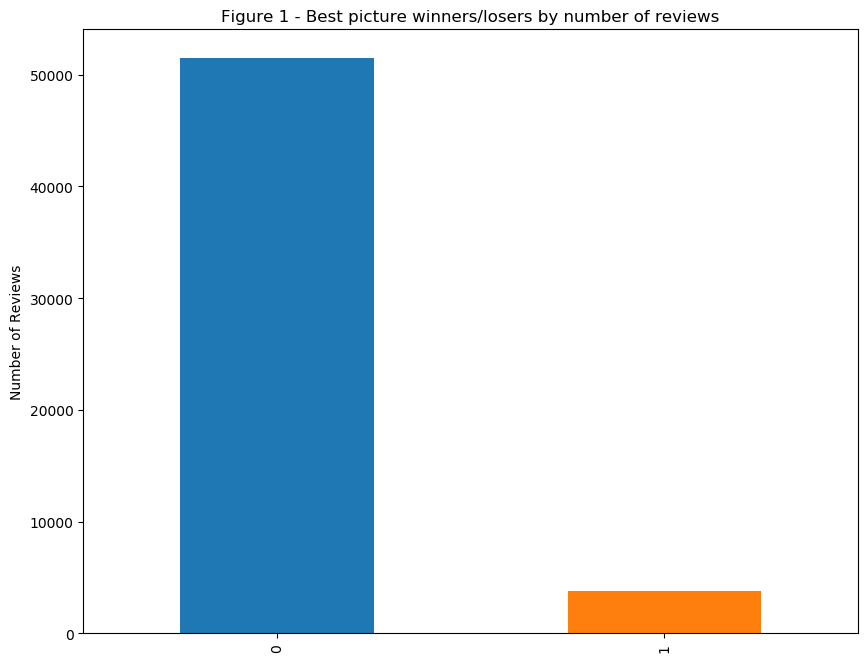

In [289]:
#Visualise the count of winners vs losers
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 100
#Visualise reviews per movie
pre_oscars_df["Winner"].value_counts().plot(kind='bar')
plt.ylabel('Number of Reviews')
plt.title('Figure 1 - Best picture winners/losers by number of reviews')

plt.show()

### NLP Task 2 - Text cleaning and feature extraction
<font size=4>The review comments data contained in the pre\_oscars\_df dataframe will be used to extract features for training the classification model with. For this NLP task we are interested in identifying the frequency of text from the reviews. The function text\_clean takes the entire list of review comments and performs the following functions:
    1. Tokenizes each review using the regular expresion (r'\w+'). This will return words and numbers and strips out punctuation and whitespace.
    2. Tags the tokenized words using the nltk.pos_tag function.
    3. Removes words contained in the nltk.stopwords.words("english") list.
    4. Performs lemmatizing on the filtered word list to reduce words to base.
    5. Returns the cleaned and tokenized words.
    
All reviews contained in pre\_oscars\_df cleaned with text_clean() function and saved as new column "clean\_text". The text features will be extracted with the TfidfVectorizer from the sklearn.feature_extraction.text package. The function vectorize_data() is utilised to set the parameters of the TfidfVectorizer for use during model optimisation.

In [290]:
#Function to clean text of review comments ***Note still has numbers in it***
def text_clean(raw_corpus):
    corpus = []
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    for i in tqdm(raw_corpus.index):
        tokens = tokenizer.tokenize(raw_corpus[i])
        tokens = nltk.Text(tokens)
        tagged_text = nltk.pos_tag(tokens)
        stop_words = nltk.corpus.stopwords.words("english")
        text_out = [(w,t) for (w,t) in tagged_text if not w in set(stop_words)]
        text_out = [lemmatizer.lemmatize(w) for (w,t) in text_out]
        text_out = ' '.join(text_out)
        text_out = text_out.lower()
        corpus.append(text_out)
    return corpus

In [291]:
pre_oscars_df["clean_text"] = text_clean(pre_oscars_df["Comments"])

100%|██████████| 55286/55286 [09:40<00:00, 95.23it/s] 


In [292]:
#Vectorize the features
def vectorize_data(feature_corpus, tfidf_ngram = (1,1), use_idf=True, max_df = 0.9, min_df = 0.001):
    tfidf = TfidfVectorizer(ngram_range = tfidf_ngram, max_df=max_df, min_df=min_df,use_idf=use_idf)
    tfidf.fit(feature_corpus)
    return tfidf

### NLP Task 2 - Model Training and Optimisation
<font size=4>The machine learning algorithm being used is the RandomForestClassifier from the sklearn.ensemble package. The three functions shown below, rf_clf_model, train_clf_model and apply_clf_model are used to investigate the performance for differing values of hyperparameters of the random forest model. The performance metrics used are Precision, Recall, Accuracy and f1 score.
    
The model is trained for varying values of hyperparameters n_estimators, criterion and depth and the performance for each iteration is recorded. The effect of changing the number of estimators over 50 was negligible but did improve at n = 1000, however the training time increases substantially for larger values so 100 was chosen for the purpose of further evaluation. The criterion 'gini' was significantly better performing than 'entropy'. Adjusting max\_depth does not significantly affect performance to a depth of 1000, at depth of 100 the performance was worse. There is some suggestion that selecting max_depth between 5000 and 1000 may improve recall so 1000 is selected.  

The following hyperparameter values were selected:  
n_trees = 100  
criterion = "gini"   
max_depth = 1000 
   
With the selected hyperparameters further investigation was undertaken on the vectorizer parameter ngram_range. It was found using ngram (1,3) provided the best performance for the classifier.

The best performing model had the following metrics:  
Precision: loser = 0.97585498   winner = 0.94083694  
Recall: loser = 0.99681008    winner = 0.67285862  
f1 score: loser = 0.98622123  winner = 0.78459687   
Overall Accuracy =  0.97409926  

 
The metrics we are most interested in are the recall and precision of the reviews classified as Winners, which at 0.67 and 0.94 respectively suggest the model is performing well. It is finding 67% of the winners reviews and only 6% of reviews classified as winners are incorrect. Overall the performance of the model is encouraging. However we have trained this model with a random selection of all movies and bias will exist due to names of the movies, actors and directors for example. The real test is to completely isolate a selection of movies and train the model with the others. This was completed and the results are summarised here:  
#### 2015
Actual Winner - Birdman

Predicted Winner - Birdman (Although very small margin, 0.36% to 0.32% for Whiplash)
#### 2016
Actual Winner - Spotlight

Predicted Winner - Spotlight (35.22% vs The Revenant 21.75% and Mad Max:Fury road 0.22%)
#### 2017
Actual Winner - Moonlight

Predicted Winner - Moonlight (35.87% vs Hidden Figures 18.72% and La La Land 0.77%)
#### 2018
Actual Winner - The shape of water

Predicted Winner - Three billboards outside Ebbing, Missouri (58.72% vs Lady Bird 3.46% and The shape of water 2.78%)
#### 2019
Actual Winner - Green Book

Predicted Winner - Green Book (20.43% vs Roma 2.43% and The favourite 0.68%)
#### 2020
Actual Winner - Parasite

Predicted Winner - Ford v Ferrari (0.74% vs 1917 0.2% and Once upon a time in Hollywood 0.19%)
#### 2021
Actual Winner - Nomadland

Predicted Winner - Minari (36.94% vs The trial of the Chicago 7 6.04% and Nomadland 0.4%)  

The model has predicted 4 out of 7 correctly, though Birdman in 2015 was not a strong result. This method could have some merit and further exploration of the training data may improve the results. More data prior to 2015 may provide better insights, or application of word2vec and a neural network may find more patterns describing the winners and improve results. 

In [293]:
def rf_clf_model(n_trees = 100, criterion="entropy", max_depth = None):
    clf_model = RandomForestClassifier(n_estimators=n_trees, criterion=criterion, max_depth=max_depth)  #criterion = "gini","entropy"
    return clf_model

def train_clf_model(X_train,y_train, clf_model):
    clf_model.fit(X_train,y_train)
    return clf_model
    
def apply_clf_model(X_test, y_test, clf_model):
    y_pred = clf_model.predict(X_test)
    probs = clf_model.predict_proba(X_test)
    probs = probs[:, 1] #flatten the probs array
    m_precision, m_recall, _ = precision_recall_curve(y_pred, probs)
    precision = precision_score(y_test, y_pred, average=None, pos_label=None)  #, labels=list_of_labels
    recall = recall_score(y_test, y_pred, average=None, pos_label=None)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average=None, pos_label=None)
    return y_pred, probs, precision, recall, accuracy, f1

In [303]:
#plot roc curve    
def plot_roc_auc(y_test,probs, classifier):
    nm_probs = [0 for _ in range(len(y_test))]
    # calculate scores
    nm_auc = roc_auc_score(y_test, nm_probs)
    m_auc = roc_auc_score(y_test, probs)
    # summarize scores
    print('No Model: ROC AUC=%.3f' % (nm_auc))
    print('{}: ROC AUC={}'.format(classifier,m_auc))
    # calculate roc curves
    nm_fpr, nm_tpr, _ = roc_curve(y_test, nm_probs)
    fpr, tpr, _ = roc_curve(y_test, probs)
    # plot the roc curve for the model
    plt.plot(nm_fpr, nm_tpr, linestyle='--', label='No Model')
    plt.plot(fpr, tpr, marker='.', label=str(classifier))
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [295]:
#Use a traditional train/test split to compare hyperparameters of random forest model
y = pre_oscars_df["Winner"].values
X_train, X_test, y_train, y_test = train_test_split(pre_oscars_df["clean_text"], y, test_size=0.25, random_state=42)
#set the vectorizer with only training data
tfidf = vectorize_data(X_train, tfidf_ngram = (1,1), use_idf=True, max_df = 0.9, min_df = 0.001)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

In [297]:
#Check performance of adjusting number of trees used for random forest
for n_trees in [10, 50, 100, 1000]:
    clf_model = rf_clf_model(n_trees = n_trees)
    clf_model = train_clf_model(X_train,y_train, clf_model)
    y_pred, probs, precision, recall, accuracy, f1 = apply_clf_model(X_test, y_test, clf_model)
    print("**************************************************")
    print("Metrics for number of trees = {}".format(n_trees))
    print("Precision = {}".format(precision))
    print("Recall = {}".format(recall))
    print("Accuracy = {}".format(accuracy))
    print("f1 score = {}".format(f1))

**************************************************
Metrics for number of trees = 10
Precision = [0.96672438 0.97773655]
Recall = [0.99906637 0.54385965]
Accuracy = 0.9671538127622631
f1 score = [0.98262932 0.69893899]
**************************************************
Metrics for number of trees = 50
Precision = [0.9688537  0.98932384]
Recall = [0.99953318 0.57378741]
Accuracy = 0.9696860078136305
f1 score = [0.98395435 0.72632266]
**************************************************
Metrics for number of trees = 100
Precision = [0.97016842 0.98795181]
Recall = [0.99945538 0.59236326]
Accuracy = 0.9709159311242946
f1 score = [0.98459416 0.74064516]
**************************************************
Metrics for number of trees = 1000
Precision = [0.97053268 0.98637138]
Recall = [0.99937758 0.59752322]
Accuracy = 0.9712053248444509
f1 score = [0.98474394 0.74421594]


In [298]:
#Check performance of adjusting criterion used for random forest
for criterion in ["gini","entropy"]:
    clf_model = rf_clf_model(n_trees = 100, criterion = criterion)
    clf_model = train_clf_model(X_train,y_train, clf_model)
    y_pred, probs, precision, recall, accuracy, f1 = apply_clf_model(X_test, y_test, clf_model)
    print("**************************************************")
    print("Metrics for criterion = {}".format(criterion))
    print("Precision = {}".format(precision))
    print("Recall = {}".format(recall))
    print("Accuracy = {}".format(accuracy))
    print("f1 score = {}".format(f1))

**************************************************
Metrics for criterion = gini
Precision = [0.97461234 0.95345345]
Recall = [0.99758811 0.65531476]
Accuracy = 0.9735928230357401
f1 score = [0.9859664  0.77675841]
**************************************************
Metrics for criterion = entropy
Precision = [0.96994866 0.98788927]
Recall = [0.99945538 0.58926729]
Accuracy = 0.9706988858341774
f1 score = [0.98448097 0.73820297]


In [299]:
#Check performance of adjusting max_depth used for random forest
for max_depth in [None,5000,1000,100]:
    clf_model = rf_clf_model(n_trees = 100, criterion = "gini", max_depth = max_depth)
    clf_model = train_clf_model(X_train,y_train, clf_model)
    y_pred, probs, precision, recall, accuracy, f1 = apply_clf_model(X_test, y_test, clf_model)
    print("**************************************************")
    print("Metrics for maximum depth = {}".format(max_depth))
    print("Precision = {}".format(precision))
    print("Recall = {}".format(recall))
    print("Accuracy = {}".format(accuracy))
    print("f1 score = {}".format(f1))

**************************************************
Metrics for maximum depth = None
Precision = [0.97476053 0.95359281]
Recall = [0.99758811 0.65737874]
Accuracy = 0.9737375198958182
f1 score = [0.98604222 0.7782529 ]
**************************************************
Metrics for maximum depth = 5000
Precision = [0.97482124 0.94378698]
Recall = [0.99704349 0.65841073]
Accuracy = 0.9733034293155839
f1 score = [0.98580715 0.77568389]
**************************************************
Metrics for maximum depth = 1000
Precision = [0.97474709 0.9437037 ]
Recall = [0.99704349 0.65737874]
Accuracy = 0.9732310808855448
f1 score = [0.98576923 0.77493917]
**************************************************
Metrics for maximum depth = 100
Precision = [0.96950483 0.98432056]
Recall = [0.99929977 0.58307534]
Accuracy = 0.9701200983938648
f1 score = [0.98417685 0.7323396 ]


In [300]:
#change the ngram size
for ngram in [(1,2),(1,3),(2,2),(2,3)]:
    tfidf = vectorize_data(pre_oscars_df["clean_text"], tfidf_ngram = ngram, use_idf=True, max_df = 0.9, min_df = 0.001)
    X = tfidf.transform(pre_oscars_df["clean_text"])
    y = pre_oscars_df["Winner"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    clf_model = rf_clf_model(n_trees = 100, criterion = "gini", max_depth = 1000)
    clf_model = train_clf_model(X_train,y_train, clf_model)
    y_pred, probs, precision, recall, accuracy, f1 = apply_clf_model(X_test, y_test, clf_model)
    print("**************************************************")
    print("Metrics for ngram = {}".format(ngram))
    print("Precision = {}".format(precision))
    print("Recall = {}".format(recall))
    print("Accuracy = {}".format(accuracy))
    print("f1 score = {}".format(f1))

**************************************************
Metrics for ngram = (1, 2)
Precision = [0.97570819 0.94202899]
Recall = [0.99688789 0.67079463]
Accuracy = 0.9740269136159745
f1 score = [0.98618434 0.78360458]
**************************************************
Metrics for ngram = (1, 3)
Precision = [0.97585498 0.94083694]
Recall = [0.99681008 0.67285862]
Accuracy = 0.9740992620460136
f1 score = [0.98622123 0.78459687]
**************************************************
Metrics for ngram = (2, 2)
Precision = [0.96645718 0.85528455]
Recall = [0.99307555 0.54282766]
Accuracy = 0.9615106352192158
f1 score = [0.97958557 0.66414141]
**************************************************
Metrics for ngram = (2, 3)
Precision = [0.9663236  0.86184211]
Recall = [0.99346456 0.54076367]
Accuracy = 0.961727680509333
f1 score = [0.97970614 0.66455295]


**********************************************************************
Precision = [0.83061287 0.66666667]
Recall = [0.99962936 0.00362319]
Accuracy = 0.8304615384615385
f1 score = [0.90731707 0.00720721]
No Model: ROC AUC=0.500
RandomForest: ROC AUC=0.7611535920327457


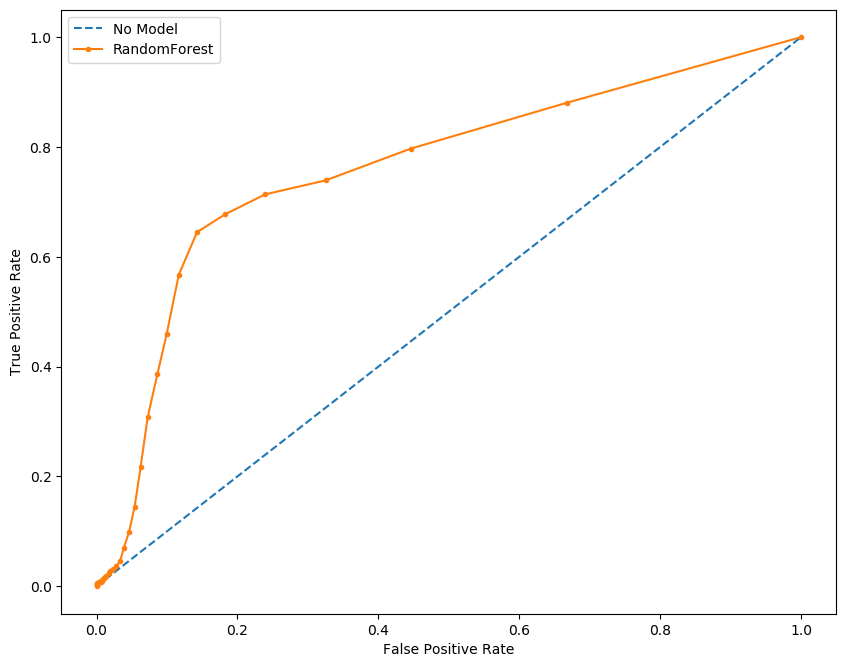

2015 Best Picture Winner: BIRDMAN OR (THE UNEXPECTED VIRTUE OF IGNORANCE)
THE GRAND BUDAPEST HOTEL = 0.0% of predicted Oscar winner
AMERICAN SNIPER = 0.0% of predicted Oscar winner
WHIPLASH = 0.32% of predicted Oscar winner
THE IMITATION GAME = 0.0% of predicted Oscar winner
BOYHOOD = 0.0% of predicted Oscar winner
SELMA = 0.0% of predicted Oscar winner
THE THEORY OF EVERYTHING = 0.0% of predicted Oscar winner
BIRDMAN OR (THE UNEXPECTED VIRTUE OF IGNORANCE) = 0.36% of predicted Oscar winner
**********************************************************************

**********************************************************************
Precision = [0.95937024 0.31521739]
Recall = [0.95235694 0.35222672]
Accuracy = 0.9171808258186995
f1 score = [0.95585073 0.33269598]
No Model: ROC AUC=0.500
RandomForest: ROC AUC=0.6511773752894578


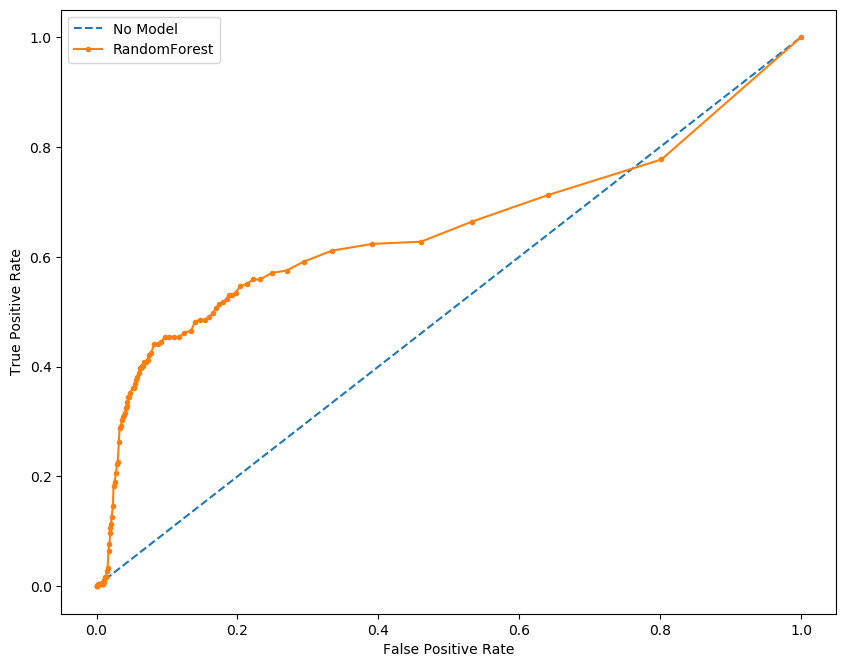

2016 Best Picture Winner: SPOTLIGHT
THE BIG SHORT = 0.0% of predicted Oscar winner
ROOM = 0.0% of predicted Oscar winner
MAD MAX: FURY ROAD = 0.22% of predicted Oscar winner
THE MARTIAN = 0.0% of predicted Oscar winner
BRIDGE OF SPIES = 0.0% of predicted Oscar winner
THE REVENANT = 21.75% of predicted Oscar winner
BROOKLYN = 0.0% of predicted Oscar winner
SPOTLIGHT = 35.22% of predicted Oscar winner
**********************************************************************

**********************************************************************
Precision = [0.95653495 0.62992126]
Recall = [0.98528491 0.35874439]
Accuracy = 0.9443956687152473
f1 score = [0.9706971  0.45714286]
No Model: ROC AUC=0.500
RandomForest: ROC AUC=0.7098729119340916


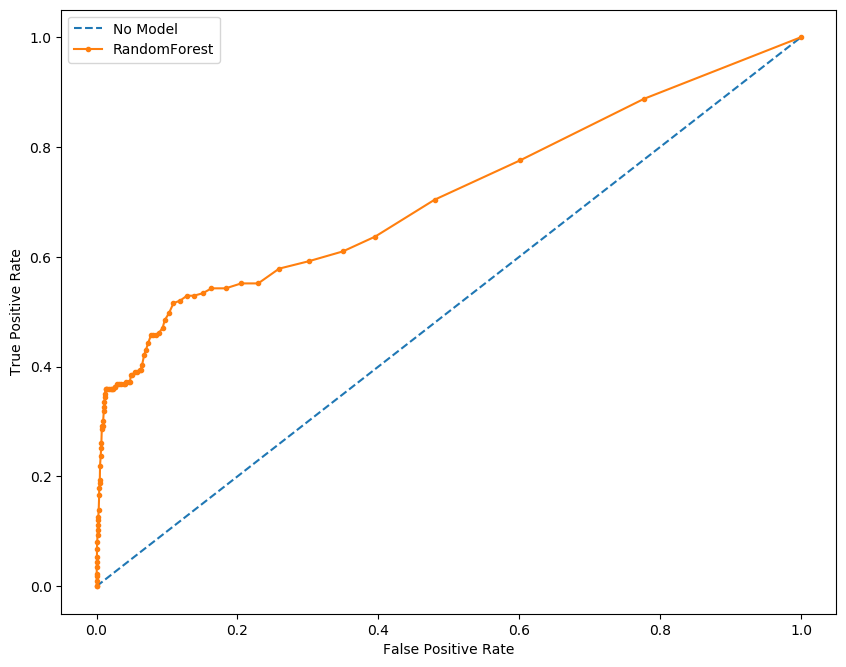

2017 Best Picture Winner: MOONLIGHT
HELL OR HIGH WATER = 0.0% of predicted Oscar winner
HIDDEN FIGURES = 18.72% of predicted Oscar winner
FENCES = 0.0% of predicted Oscar winner
MOONLIGHT = 35.87% of predicted Oscar winner
LA LA LAND = 0.77% of predicted Oscar winner
MANCHESTER BY THE SEA = 0.0% of predicted Oscar winner
LION = 0.0% of predicted Oscar winner
ARRIVAL = 0.53% of predicted Oscar winner
HACKSAW RIDGE = 0.26% of predicted Oscar winner
**********************************************************************

**********************************************************************
Precision = [0.89214176 0.04081633]
Recall = [0.92492013 0.02777778]
Accuracy = 0.832378223495702
f1 score = [0.90823529 0.03305785]
No Model: ROC AUC=0.500
RandomForest: ROC AUC=0.6085983514811676


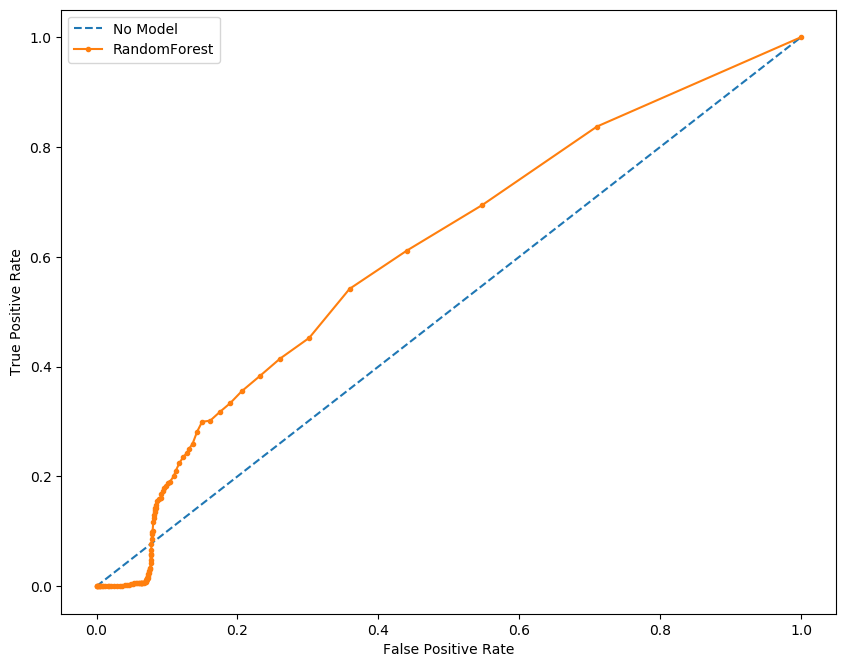

2018 Best Picture Winner: THE SHAPE OF WATER
THREE BILLBOARDS OUTSIDE EBBING, MISSOURI = 58.72% of predicted Oscar winner
DARKEST HOUR = 0.66% of predicted Oscar winner
GET OUT = 0.36% of predicted Oscar winner
DUNKIRK = 0.06% of predicted Oscar winner
LADY BIRD = 3.46% of predicted Oscar winner
THE POST = 1.27% of predicted Oscar winner
CALL ME BY YOUR NAME = 2.31% of predicted Oscar winner
PHANTOM THREAD = 0.0% of predicted Oscar winner
THE SHAPE OF WATER = 2.78% of predicted Oscar winner
**********************************************************************

**********************************************************************
Precision = [0.95362035 0.76582278]
Recall = [0.99621793 0.20336134]
Accuracy = 0.9507612256696859
f1 score = [0.97445383 0.32138114]
No Model: ROC AUC=0.500
RandomForest: ROC AUC=0.728723810898171


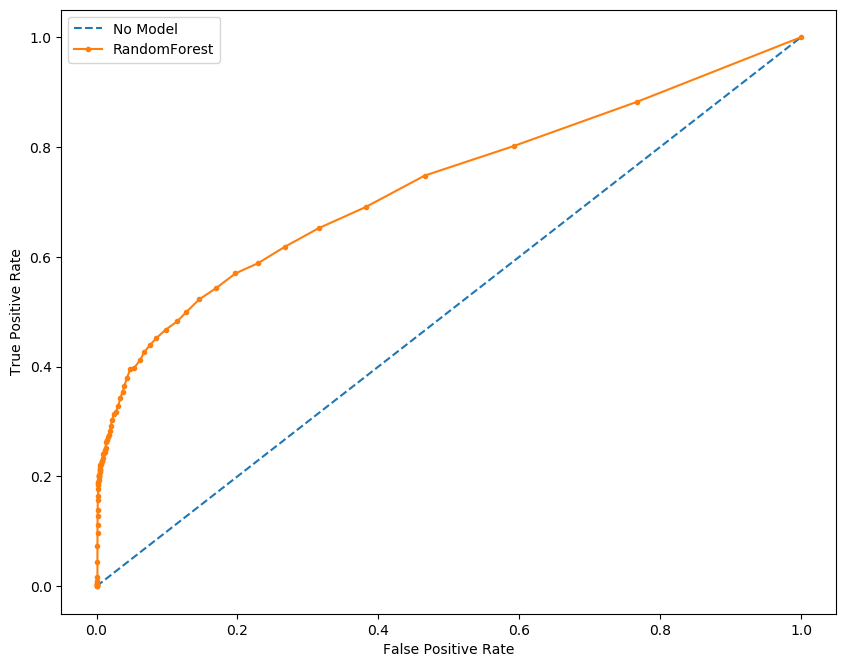

2019 Best Picture Winner: GREEN BOOK
BLACK PANTHER = 0.3% of predicted Oscar winner
A STAR IS BORN = 0.0% of predicted Oscar winner
BLACKKKLANSMAN = 0.17% of predicted Oscar winner
GREEN BOOK = 20.34% of predicted Oscar winner
BOHEMIAN RHAPSODY = 0.15% of predicted Oscar winner
VICE = 0.24% of predicted Oscar winner
THE FAVOURITE = 0.68% of predicted Oscar winner
ROMA = 2.43% of predicted Oscar winner
**********************************************************************

**********************************************************************
Precision = [0.95401457 0.04347826]
Recall = [0.99822538 0.00167364]
Accuracy = 0.9524029397052599
f1 score = [0.97561937 0.00322321]
No Model: ROC AUC=0.500
RandomForest: ROC AUC=0.5462252137529561


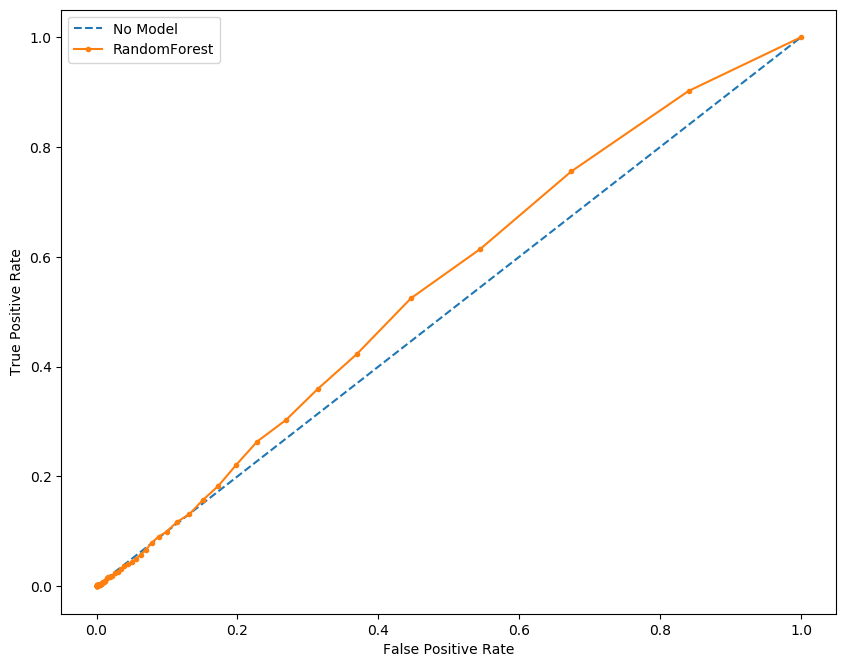

2020 Best Picture Winner: PARASITE
THE IRISHMAN = 0.07% of predicted Oscar winner
PARASITE = 0.17% of predicted Oscar winner
JOJO RABBIT = 0.11% of predicted Oscar winner
1917 = 0.2% of predicted Oscar winner
FORD V FERRARI = 0.74% of predicted Oscar winner
JOKER = 0.16% of predicted Oscar winner
ONCE UPON A TIME...IN HOLLYWOOD = 0.19% of predicted Oscar winner
LITTLE WOMEN = 0.0% of predicted Oscar winner
MARRIAGE STORY = 0.09% of predicted Oscar winner
**********************************************************************



In [304]:
#Run through years we have data for and predict best picture winner
for year_oscars in range(2015,2021):
    split_index = [i for i in pre_oscars_df.index if pre_oscars_df.loc[i]["Date_oscars"].year == year_oscars]
    test_df = pre_oscars_df.loc[split_index]
    train_df =pre_oscars_df.drop(split_index)
    tfidf = vectorize_data(train_df["clean_text"], tfidf_ngram = (1,3), use_idf=True, max_df = 0.9, min_df = 0.001)
    X_train = tfidf.transform(train_df["clean_text"])
    X_test = tfidf.transform(test_df["clean_text"])
    y_train = train_df["Winner"].values
    y_test = test_df["Winner"].values
    clf_model = rf_clf_model(n_trees = 100, criterion = "gini", max_depth = 1000)
    clf_model = train_clf_model(X_train,y_train, clf_model)
    y_pred, probs, precision, recall, accuracy, f1 = apply_clf_model(X_test, y_test, clf_model)
    print("**********************************************************************")
    print("Precision = {}".format(precision))
    print("Recall = {}".format(recall))
    print("Accuracy = {}".format(accuracy))
    print("f1 score = {}".format(f1))
    plot_roc_auc(y_test, probs, "RandomForest")
    test_df["Predicted_Winner"] = y_pred
    movie_list = set(test_df["Title"])
    actual_winner = [test_df.loc[i]["Title"] for i in test_df.index if test_df.loc[i]["Winner"]]
    print("{} Best Picture Winner: {}".format(year_oscars, actual_winner[0]))
    for movie in movie_list:
        count = [test_df.loc[i]["Predicted_Winner"] for i in test_df.index if test_df.loc[i]["Title"] == movie]
        count_sum = sum(count)
        total = len(count) #use this to find percentage of winner reviews as percentage of reviews for that movie only
        print("{} = {}% of predicted Oscar winner".format(movie,round(count_sum/total*100,2)))
    print("**********************************************************************\n")

### NLP Task 2 - Model Deployment
<font size=4>To simulate how the model would work in deployment the model is trained with the entire pre\_oscars\_df dataframe minus the 2021 data. The model and vectorizer are saved as pickle files for easy deployment. The model can be deployed and updated remotely as long as it can be directed to the latest pickle files. best_picture_model_deploy() function takes a dataframe containing movie titles and reviews and returns a dataframe with the movie titles and percentage of reviews predicting a best picture winner.The example below is for the 2021 nominees.

The NLP task provides a measure that can be interpreted to determine the most likely movie in the list to win the best picture oscar that year. Further work needs to be done to improve the predictive ability of the model. More review data prior to 2015 could be used to train the model.

In [314]:
#Train the model and save it
tfidf = vectorize_data(pre_oscars_df["clean_text"], tfidf_ngram = (1,2), use_idf=True, max_df = 0.9, min_df = 0.001)
split_index = [i for i in pre_oscars_df.index if pre_oscars_df.loc[i]["Date_oscars"].year == 2021]
train_df =pre_oscars_df.drop(split_index)
X_train = tfidf.transform(train_df["clean_text"])
y_train = train_df["Winner"].values
clf_model = rf_clf_model(n_trees = 100, criterion = "gini", max_depth = 1000)
clf_model = train_clf_model(X_train,y_train, clf_model)
#Save the model and vectorizer
rfclf_Filename = "Pickle_rfclf_Model.pkl"  
tfidf_Filename = "Pickle_tfidf_rf.pkl"

pickle.dump(clf_model, open(rfclf_Filename, 'wb'))
pickle.dump(tfidf, open(tfidf_Filename, 'wb'))

In [315]:
#This is the deployable code. Note must be able to find the text_clean function
#Load in saved model, vectorizer
rfclf_Filename = "Pickle_rfclf_Model.pkl"  
tfidf_Filename = "Pickle_tfidf_rf.pkl"

loaded_rfclf = pickle.load(open(rfclf_Filename, 'rb'))
loaded_tfidf = pickle.load(open(tfidf_Filename, 'rb'))

def best_picture_model_deploy(reviews):
    """Input a dataframe of movie reviews with column = "Comments" containing reviews and column = "Title" containing
    movie titles
    Will return a dataframe with column "Title" with movie titles and column = "Percent_Winner" containing the
    percentage of reviews for each movie classified as a best picture winner. Highest percentage is the predicted
    best picture winner"""
    results = pd.DataFrame(columns = ['Title','Percent_Winner'])
    reviews["clean_text"] = text_clean(reviews["Comments"])
    X = loaded_tfidf.transform(reviews["clean_text"])
    y_pred = loaded_rfclf.predict(X)
    movie_list = set(reviews["Title"])
    reviews["Predicted_Winner"] = y_pred
    for movie in movie_list:
        count = [reviews.loc[i]["Predicted_Winner"] for i in reviews.index if reviews.loc[i]["Title"] == movie]
        count_sum = sum(count)
        total = len(count) #use this to find percentage of winner reviews as percentage of reviews for that movie only
        percent_result = round(count_sum/total*100,2)
        results.loc[len(results)] = [movie, percent_result]
    return results

In [316]:
#Check the code works by punching in the 2021 movies
split_index = [i for i in pre_oscars_df.index if pre_oscars_df.loc[i]["Date_oscars"].year == 2021]
test_df = pre_oscars_df.loc[split_index]
best_picture_model_deploy(test_df)

100%|██████████| 3152/3152 [00:27<00:00, 116.60it/s]


,Title,Percent_Winner
0,THE FATHER,0.26
1,JUDAS AND THE BLACK MESSIAH,0.37
2,THE TRIAL OF THE CHICAGO 7,6.04
3,MINARI,36.94
4,MANK,0.19
5,PROMISING YOUNG WOMAN,0.15
6,NOMADLAND,0.40
